### MARS Multi Modal Knowledge Graph

In [1]:
import os
import torch
from transformers import CLIPProcessor, CLIPModel
from fastprogress import progress_bar
import glob
from PIL import Image
import h5py
import matplotlib.pyplot as plt
import networkx as nx
import torch.nn.functional as F
import numpy as np
import seaborn as sns

/home/sha/anaconda3/envs/dvaa/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### 0. Setting

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
def get_ranges(n, interval):
    ranges = []
    for start in range(0, n, interval):
        if start + interval > n:
            end = n
        else:
            end = start + interval
        ranges.append((start, end))
    return ranges

In [4]:
def show_images(img_list, figsize=(15, 3)):
    n = len(img_list)
    plt.figure(figsize=figsize)
    for i, img in enumerate(img_list):
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [5]:
def draw_knowledge_graph(KG, query, seed=42):
    G = nx.DiGraph()
    for h, r, t in KG:
        G.add_node(h)
        G.add_node(t)
        G.add_edge(h, t, label=r)

    pos = nx.spring_layout(G, seed=seed)
    node_colors = ['orange' if 'IMG:' in node else 'skyblue' for node in G.nodes()]

    plt.figure(figsize=(10, 6))
    nx.draw(G, pos, with_labels=True, node_size=3000, node_color=node_colors,
            font_size=10, edge_color='gray', arrows=True)

    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

    title=f"Retrieved Knowledge Graph (Query: {query})"
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [6]:
@torch.no_grad()
def get_clip_image_embeddings(images, clip_processor, clip_model, device):
    inputs = clip_processor(images=images, return_tensors="pt").to(device)
    return clip_model.get_image_features(**inputs) # [num of images, dimenstion]

@torch.no_grad()
def get_clip_text_embeddings(texts, clip_processor, clip_model, device):
    inputs = clip_processor(text=texts, return_tensors="pt", padding=True).to(device)
    return clip_model.get_text_features(**inputs) # [num of texts, dimenstion]

In [7]:
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

---

#### 1. Knowledge Graph Construction

In [8]:
def get_entity_dict(path):
    entity_dict = {}
    with open(path, "r") as enidf:
        for line in enidf.readlines():
            entity_dict[line.split('\t')[0]] = line.split('\t')[1][:-1]
    return entity_dict

def get_relation_dict(path):
    relation_dict = {}
    with open(path, "r") as enidf:
        for line in enidf.readlines():
            relation_dict[line.split('\t')[0]] = line.split('\t')[1][:-1]
    return relation_dict

In [9]:
def get_entity_list(graph):
    return sorted(list({h for h, _, _ in graph} | {t for _, _, t in graph}))

def get_relation_list(graph):
    return sorted(list({r for _, r, _ in graph}))

def get_ad_list(graph):
    ad_list = {}
    for head, rel, tail in graph:
        if head not in ad_list:
            ad_list[head] = {tail: rel}
        else:
            ad_list[head][tail] = rel
    return ad_list

def get_entity_embeddings(entity_list, clip_processor, clip_model, device, clip_len=1000):
    clip_ranges = get_ranges(len(entity_list), clip_len) 
    embed_list = []
    for clip_range in clip_ranges:
        start, end = clip_range[0], clip_range[1]
        embed = get_clip_text_embeddings(entity_list[start:end], clip_processor, clip_model, device) 
        embed_list.append(embed)
    embeddings = torch.cat(embed_list, dim=0)
    return embeddings

In [10]:
class MARS_KG:
    def __init__(self, path, entity_dict, relation_dict, clip_model, clip_processor, device):
        self.clip_model = clip_model
        self.clip_processor = clip_processor
        self.clip_batch_size = 1000
        self.device = device

        # construct KG Data
        self.KG = []
        with open(path, "r") as enidf:
            for line in enidf.readlines():
                entity1 = entity_dict[line.split('\t')[0]]
                entity2 = entity_dict[line.split('\t')[2][:-1]]
                relation = relation_dict[line.split('\t')[1]]
                self.KG.append((entity1, relation, entity2))
        self.KG_size = len(self.KG)
        self.KG_entities = get_entity_list(self.KG)
        self.KG_relations = get_relation_list(self.KG)
        self.KG_ad_list = get_ad_list(self.KG)
        self.KG_entity_embeds = get_entity_embeddings(self.KG_entities, self.clip_processor, self.clip_model, self.device, self.clip_batch_size)

    def get_sub_KG(self, query, top_n=10, top_N=10):
        # query embedding
        if isinstance(query, str):
            query_embed = get_clip_text_embeddings([query], self.clip_processor, self.clip_model, self.device)
        else:
            query_embed = get_clip_image_embeddings([query], self.clip_processor, self.clip_model, self.device)

        # retrieve sub-graph
        query_embed_norm = F.normalize(query_embed, dim=1)
        kg_embed_norm = F.normalize(self.KG_entity_embeds, dim=1)
        similarity = query_embed_norm @ kg_embed_norm.T

        _, topn_indices = similarity.squeeze(1).topk(top_n, largest=True)
        topn_indices_np = topn_indices[0].cpu().numpy()
        sub_entities = [self.KG_entities[i] for i in topn_indices_np]

        sub_KG = []
        for se in sub_entities:
            if se in self.KG_ad_list:
                se_connection = self.KG_ad_list[se]
                for nbr in se_connection:
                    rel = se_connection[nbr]
                    sub_KG.append((se, rel, nbr))  

        # filter sub-graph
        sg_text_list = []
        for item in sub_KG:
            text = f'{item[0]}-{item[1]}-{item[2]}'
            sg_text_list.append(text)     

        sgt_embed = get_clip_text_embeddings(sg_text_list, self.clip_processor, self.clip_model, self.device)
        sgt_embed_norm =  F.normalize(sgt_embed, dim=1)
        re_similarity = query_embed_norm @ sgt_embed_norm.T

        _, re_topn_indices = re_similarity.squeeze(1).topk(top_N, largest=True)
        re_topn_indices_np = re_topn_indices[0].cpu().numpy()
        f_sub_KG = [sub_KG[i] for i in re_topn_indices_np]
        return f_sub_KG

In [11]:
entity2text_path = "MarKG/entity2text.txt"
relation2text_path = "MarKG/relation2text.txt"
kg_path = "MarKG/wiki_tuple_ids.txt"

In [12]:
entity_dict = get_entity_dict(entity2text_path)
relation_dict = get_relation_dict(relation2text_path)
mars_kg = MARS_KG(kg_path, entity_dict, relation_dict, clip_model, clip_processor, device)

In [13]:
KG_entities = mars_kg.KG_entities
KG_relations = mars_kg.KG_relations
print('Num of Entities:', len(KG_entities))
print('Num of relations:', len(KG_relations))

Num of Entities: 9903
Num of relations: 191


---

#### 2. Sub-KG Retrieval

/tmp/ipykernel_1602660/1228772825.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


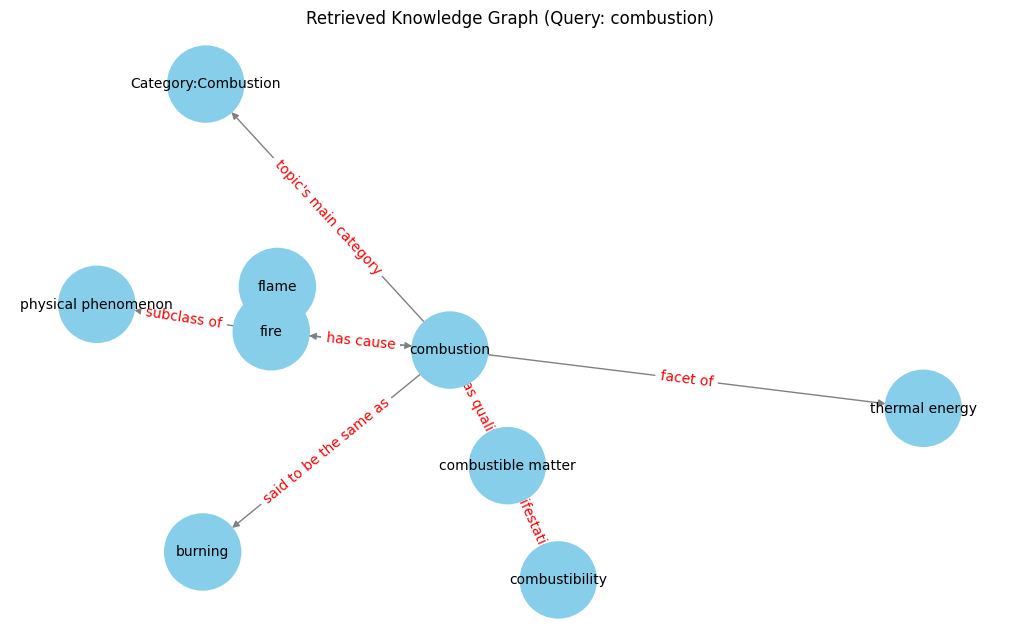

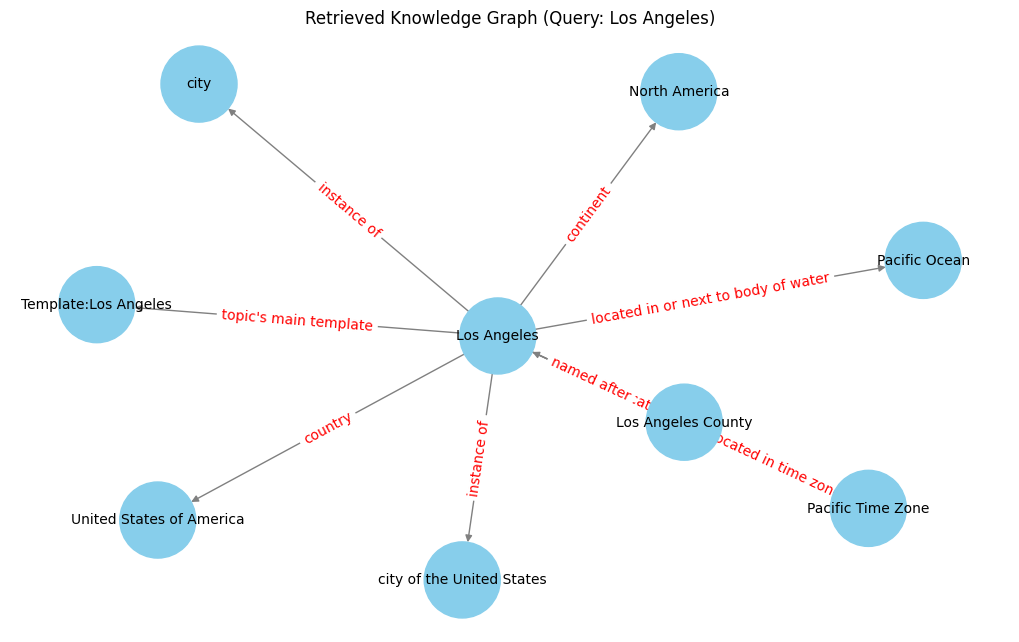

In [14]:
# query : 'combustion'
query1 = 'combustion'
sub_KG1 = mars_kg.get_sub_KG(query1)
draw_knowledge_graph(sub_KG1, query1)

# query : 'Los Angeles'
query2 = 'Los Angeles'
sub_KG2 = mars_kg.get_sub_KG(query2)
draw_knowledge_graph(sub_KG2, query2)

---

### 3. Save Image Embedding for MMKG

In [18]:
inv_entity_dict = {v: k for k, v in entity_dict.items()}
print(inv_entity_dict)

{'WikiProject Painting': 'Q14942930', 'Algeria': 'Q262', 'Michelia alba': 'Q15602263', 'mammalogy': 'Q183904', 'Category:Orchards': 'Q10053880', 'short stature-onychodysplasia-facial dysmorphism-hypotrichosis syndrome': 'Q55784387', 'intercardinal direction': 'Q10351538', 'well': 'Q43483', 'Category:Antarctica': 'Q7217296', 'protein structure': 'Q735188', 'southeast': 'Q6452640', 'Desoxyn': 'Q47521464', 'submarine': 'Q2811', 'science student': 'Q105467331', 'quail': 'Q6072584', 'Hans Albert Einstein': 'Q123371', 'Category:Odds BK': 'Q9231048', 'ampere': 'Q25272', 'disincentive': 'Q24905683', 'national defence': 'Q17991228', 'Jintan District': 'Q724520', 'The Vanguard Group': 'Q849363', 'Template:War': 'Q13479477', 'Category:Microwave ovens': 'Q55248783', 'internaut': 'Q775318', 'jewelry design': 'Q6189617', 'great white shark': 'Q129026', 'Category:Pittsburgh': 'Q6449083', 'Eliminate Down': 'Q3051005', 'herb': 'Q207123', "students' union": 'Q877998', 'pollution': 'Q58734', 'not-free co

3-1. Image Visualization

Los Angeles
MARS/images/Q65


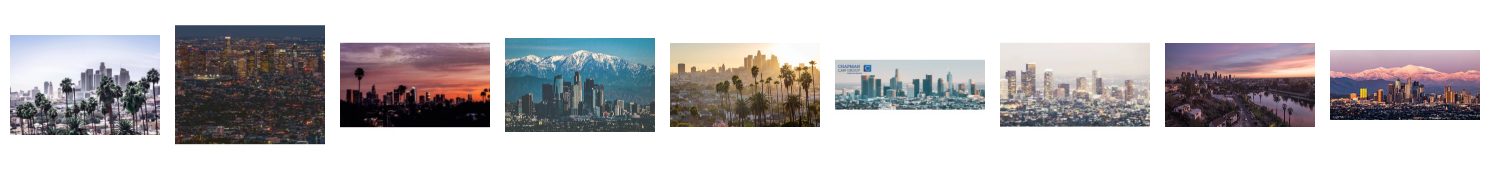

In [147]:
image_folder_path = "MARS/images"
test_name = query2
test_id = inv_entity_dict[test_name]
test_image_path = os.path.join(image_folder_path, test_id)
test_inner_list = glob.glob(f"{test_image_path}/*.*")
test_input_img = []
for item in test_inner_list:
    test_input_img.append(Image.open(item))

print(query2)
print(test_image_path)
show_images(test_input_img)

3-2. Image Embedding

In [ ]:
image_folder_path = "MARS/images"
all_img_embed = {}

for entity in progress_bar(KG_entities, total=len(KG_entities)):
    entity_id = inv_entity_dict[entity]
    
    image_path = os.path.join(image_folder_path, entity_id)
    inner_list = glob.glob(f"{image_path}/*.*")

    input_img = []
    for item in inner_list:
        im=Image.open(item)
        input_img.append(im)
    img_embed = get_clip_image_embeddings(input_img, clip_processor, clip_model, device)
    mean_img_embed = img_embed.mean(dim=0).view(1, -1) 
    all_img_embed[entity_id] = mean_img_embed.cpu().numpy()

/home/sha/anaconda3/envs/dvaa/lib/python3.8/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


3-3. Save and load embedding

In [67]:
with h5py.File("mars_image_embeddings.h5", "w") as h5_file:
    for id, vec in all_img_embed.items():
        h5_file.create_dataset(id, data=vec)

In [16]:
loaded_all_img_embed = {}
with h5py.File("mars_image_embeddings.h5", "r") as h5_file:
    for key in h5_file:
        loaded_all_img_embed[key] = h5_file[key][:]

print(loaded_all_img_embed.keys())
print(len(loaded_all_img_embed.keys()))

dict_keys(['Q100000001', 'Q10008133', 'Q1001059', 'Q1001381', 'Q100212002', 'Q100257358', 'Q1002689', 'Q100293148', 'Q1003717', 'Q1004', 'Q10042817', 'Q100434640', 'Q1004435', 'Q10053880', 'Q1005887', 'Q1006733', 'Q10069339', 'Q100710225', 'Q100781357', 'Q100859622', 'Q100860083', 'Q100863074', 'Q100935224', 'Q100999455', 'Q101017', 'Q101051813', 'Q1010519', 'Q101097118', 'Q10116375', 'Q101243423', 'Q101248333', 'Q101352', 'Q10144459', 'Q101462', 'Q101539', 'Q10157973', 'Q101687', 'Q101757284', 'Q101761', 'Q1018075', 'Q101815', 'Q10184579', 'Q101860688', 'Q10189809', 'Q10198660', 'Q101998', 'Q102066', 'Q102078', 'Q10208464', 'Q1020994', 'Q102112996', 'Q102165', 'Q102167691', 'Q10217686', 'Q102177645', 'Q102182880', 'Q102187260', 'Q102205', 'Q1022113', 'Q102231', 'Q102289', 'Q102385', 'Q10238627', 'Q102397207', 'Q102421356', 'Q102470', 'Q10250276', 'Q10251', 'Q10253316', 'Q1025438', 'Q1025847', 'Q1026040', 'Q10262281', 'Q10262289', 'Q1027846', 'Q102798', 'Q1028', 'Q1028259', 'Q10282840'

3-4. Test

In [19]:
test_name = query2
test_id = inv_entity_dict[test_name]

test_img_embed_np = loaded_all_img_embed[test_id]
print(test_id, test_name, test_img_embed_np.shape)

Q65 Los Angeles (1, 512)


In [20]:
sub_KG_et1 = get_entity_list(sub_KG1)
sub_KG_et2 = get_entity_list(sub_KG2)
test_texts = sub_KG_et1[:5] + sub_KG_et2[:5] # 5 related text, 5 unrelated text
print(test_texts)

['Category:Combustion', 'burning', 'combustibility', 'combustible matter', 'combustion', 'Los Angeles', 'Los Angeles County', 'North America', 'Pacific Ocean', 'Pacific Time Zone']


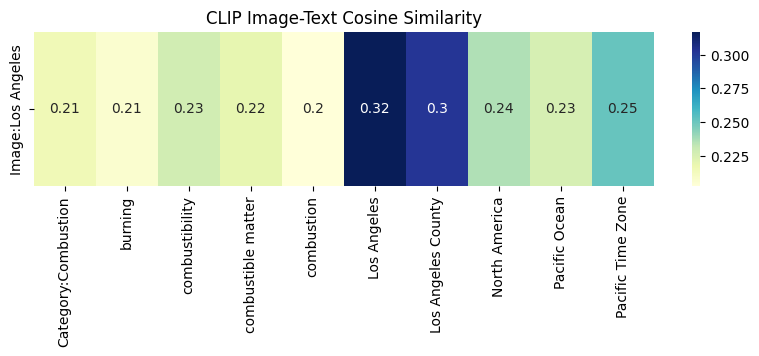

In [21]:
# get embedding
test_img_embed = torch.from_numpy(test_img_embed_np).to(device)
test_text_embed = get_clip_text_embeddings(test_texts, clip_processor, clip_model, device)

# calc similarity 
test_img_embed = F.normalize(test_img_embed, dim=1)
test_text_embed = F.normalize(test_text_embed, dim=1)
similarity = test_img_embed @ test_text_embed.T
similarity_np = similarity.cpu().numpy()

# visualization 
plt.figure(figsize=(10, 2))
sns.heatmap(similarity_np, annot=True, cmap="YlGnBu", xticklabels=test_texts, yticklabels=[f"Image:{test_name}"])
plt.title("CLIP Image-Text Cosine Similarity")
plt.show()

---

#### 4. Construct Sub-MMKG

In [24]:
sub_MMKG = sub_KG2.copy()
relation = 'imagee of'
for entity in sub_KG_et2:
    entity_id = inv_entity_dict[entity]
    head_entity = "IMG:"+entity_id
    item = (head_entity, relation, entity)
    sub_MMKG.append(item)
    print(f'({head_entity})-({relation})-({entity})')

(IMG:Q65)-(imagee of)-(Los Angeles)
(IMG:Q104994)-(imagee of)-(Los Angeles County)
(IMG:Q49)-(imagee of)-(North America)
(IMG:Q98)-(imagee of)-(Pacific Ocean)
(IMG:Q847142)-(imagee of)-(Pacific Time Zone)
(IMG:Q13414255)-(imagee of)-(Template:Los Angeles)
(IMG:Q30)-(imagee of)-(United States of America)
(IMG:Q515)-(imagee of)-(city)
(IMG:Q1093829)-(imagee of)-(city of the United States)


/tmp/ipykernel_1602660/1228772825.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


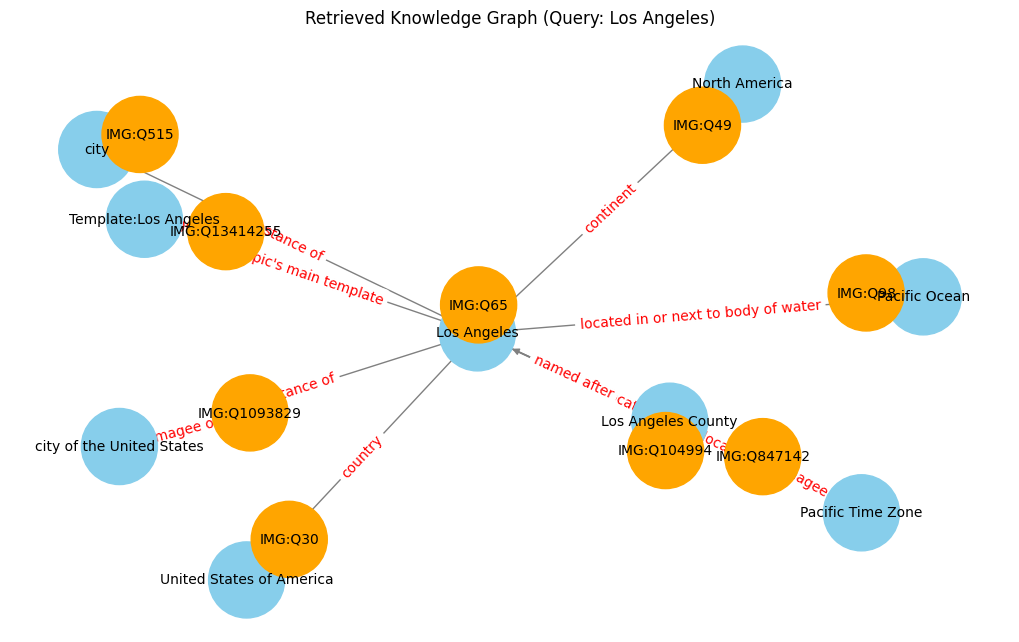

In [23]:
draw_knowledge_graph(sub_MMKG, query2)